[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/drnet_nlp_dataset.ipynb)

In [4]:
#!pip install spacy   #can take few minutes
#!python -m spacy download en
#!pip install git+https://github.com/fastai/fastai.git
!pip install torch -U # 0.4 at-least

!pip install torchtext  # for simpler datasets

!pip install git+https://github.com/IBM/pytorch-seq2seq  #for seq2seq
!pip install dill  #req of seq2seq
!pip install tqdm  #req of seq2seq

#!pip install revtok

    100% |████████████████████████████████| 519.5MB 23kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x592ae000 @  0x7f15d160a1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 51kB 3.5MB/s 
    100% |████████████████████████████████| 51kB 5.3MB/s 
  Running setup.py bdist_wheel for torchtext ... - \ done
  Stored in directory: /content/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built torchtext
  Cloning https://github.com/IBM/pytorch-seq2seq to /tmp/pip-req-build-ymw4nwv0
  Running setup.py bdist_wheel for seq2seq ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-wipqvxzc/wheels/98/b5/06/771c406b3ecc8ed34f07da72d7baf65b87e561bd9f808e91bd
Successfully bui

# Dataset with torchtext

In [147]:
from torch.utils.data import Dataset#, DataLoader
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline
import torchtext.data as data
from collections import namedtuple


TimeExample = namedtuple('TimeExample',['src','sent_0','sent_1','sent_x','is_x_0','sent_0_target'])

class TimeStyleDataset(Dataset):
  
  def __init__(self,max_id,time_mod_3_result): 
    """
    max_id how many samples are in this dataset. Size of one epoc!
    time_mod_3_result - to make sure time is train/test/valid is different, pass 0,1,2
    """
    self.max_id =int(max_id)
    #TODO : add more!!# see here: https://docs.python.org/2/library/datetime.html month can be: %b,%B,%m , year: %y,%Y
    self.formats = ["%b %d %Y %H:%M:%S", "%m/%d/%Y %H:%M:%S", "%d-%b-%Y %H.%M.%S.00",
                    "%B %d %y %H:%M:%S" ,"%B %d %H:%M:%S %Y", "%d/%B/%Y %H:%M:%S"]
    self.time_mod_3_result=time_mod_3_result
  
  def __len__(self):
    return self.max_id
  
  def _tvt(self,idx):
    # for 10, if train, return 9, valid 10, test 11
    return (idx//3) * 3 + self.time_mod_3_result #10//3 * 3 + x = 9+x
  
  def __getitem__(self,idx):
    if idx > self.max_id:
      raise IndexError(f'TimeStyleDataset {idx} is out of range {self.max_id}')
    
    """ x -  x[0] semantic0   , style0
             x[1] semantic0   , style1   
             x[2] semantic0orX, style0 (1/2 the time 0 , half X)
    """
    max_time= 2*int(2e9)  #means 1970-2001
    
    random_ids = np.random.randint(low=0,high=max_time,size=2)
    idx = random_ids[0] #other_idx is 50% same, 50% other
    other_idx = random_ids[1] if np.random.randint(0,2)==0 else random_ids[0]

    idx = self._tvt(idx)
    other_idx = self._tvt(other_idx)
   
    # two random formats
    random_fs= np.random.choice(len(self.formats),size=2,replace=False)
    
    sent_0= time.strftime(self.formats[random_fs[0]],time.gmtime(idx)) 
    sent_1= time.strftime(self.formats[random_fs[1]],time.gmtime(idx)) 
    sent_x= time.strftime(self.formats[random_fs[0]],time.gmtime(other_idx))
    y = torch.FloatTensor(np.array([idx==other_idx],np.float32))
    return TimeExample(sent_0,sent_0,sent_1,sent_x,y,sent_0)

def test():
  dataset = TimeStyleDataset(1e3,1)
  for i in range(3):
    sample = dataset[i] ; print (sample)  
  print ('len',len(dataset))
  
test()




from seq2seq.dataset import SourceField,TargetField
TEXT = SourceField(batch_first =True,sequential=True,use_vocab=True, lower=False,
                            tokenize=lambda x: list(x)) # fix_length=10
"""" Wrapper class of torchtext.data.Field that forces batch_first to be True 
and prepend <sos> and append <eos> to sequences in preprocessing step. """
TEXT_TARGET = TargetField(batch_first =True,sequential=True,use_vocab=True, lower=False,
                            tokenize=lambda x: list(x)) # fix_length=10
LABEL= data.Field(batch_first=True,sequential=False,use_vocab=False, tensor_type =torch.FloatTensor)
fields = [('src',TEXT),('sent_0',TEXT),('sent_1',TEXT),('sent_x',TEXT),('is_x_0',LABEL),('sent_0_target',TEXT_TARGET)] 



ds = data.Dataset(TimeStyleDataset(1e3,1), fields)
ds_eval = data.Dataset(TimeStyleDataset(1e3,2), fields)

# usage
print (ds[2].sent_0) #not processed
print (ds[2].is_x_0) #not processed
print (f'building vocab on {len(ds)}')
TEXT.build_vocab(ds, max_size=80000)
TEXT_TARGET.build_vocab(ds, max_size=80000)
print ('vocab TEXT:',len(TEXT.vocab), TEXT.vocab.freqs.most_common()[:10])
print ('vocab TEXT_TARGET:',len(TEXT_TARGET.vocab), TEXT_TARGET.vocab.freqs.most_common()[:10])
print ('vocab <sos>',TEXT_TARGET.sos_id)
print ('vocab <eos>',TEXT_TARGET.eos_id)
print ('vocab <eos>',TEXT_TARGET.pad_token)

       

# READ:  https://github.com/mjc92/TorchTextTutorial/blob/master/01.%20Getting%20started.ipynb
train_iter = iter(data.BucketIterator( dataset=ds, batch_size=32, sort_within_batch=False,sort_key=lambda x: len(x.sent_0))) 
eval_iter =  iter(data.BucketIterator( dataset=ds_eval, batch_size=32, sort_within_batch=False,sort_key=lambda x: len(x.sent_0))) 
#performance note: the first next, takes 3.5s, the next are fast (10000 is 1s)
b= next(train_iter)
print ('b.is_x_0.type() MUST BE FLOATTENSOR',b.is_x_0.type())
print ('b_sent0',b.sent_0[0].shape,b.sent_0[1].shape)#TEXT.reverse(b.sent_0))
print ('b.src is values+len tuple',b.src[0].shape,b.src[1].shape)#TEXT.reverse(b.sent_0))
print ('b.sent_0_target',b.sent_0_target.shape)


TimeExample(src='29-Jul-2001 11.09.46.00', sent_0='29-Jul-2001 11.09.46.00', sent_1='Jul 29 2001 11:09:46', sent_x='29-Jul-2001 11.09.46.00', is_x_0=tensor([1.]), sent_0_target='29-Jul-2001 11.09.46.00')
TimeExample(src='February 23 11:31:49 1994', sent_0='February 23 11:31:49 1994', sent_1='February 23 94 11:31:49', sent_x='December 20 17:20:40 2091', is_x_0=tensor([0.]), sent_0_target='February 23 11:31:49 1994')
TimeExample(src='January 02 13:03:55 2044', sent_0='January 02 13:03:55 2044', sent_1='01/02/2044 13:03:55', sent_x='May 20 09:06:37 2008', is_x_0=tensor([0.]), sent_0_target='January 02 13:03:55 2044')
len 1000
02/06/2018 01:27:34
tensor([1.])
building vocab on 1000
vocab TEXT: 43 [('0', 11061), ('2', 8226), (' ', 8018), ('1', 7988), (':', 6714), ('3', 3928), ('4', 3873), ('5', 3676), ('9', 3268), ('/', 2700)]
vocab TEXT_TARGET: 43 [('0', 2754), ('1', 2047), ('2', 2033), (' ', 2019), (':', 1650), ('3', 962), ('4', 917), ('5', 910), ('9', 889), ('7', 647)]
vocab <sos> 0
voca

# Seq2Seq Sanity

In [6]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

import seq2seq
from seq2seq.trainer import SupervisedTrainer
from seq2seq.models import EncoderRNN, DecoderRNN, Seq2seq
from seq2seq.loss import Perplexity
from seq2seq.optim import Optimizer
from seq2seq.dataset import SourceField, TargetField
from seq2seq.evaluator import Predictor



# Prepare dataset
src = SourceField()
tgt = TargetField()
max_len = 20
src = TEXT
tgt = TEXT_TARGET
input_vocab = src.vocab
output_vocab = tgt.vocab
train = ds
dev = ds_eval

# NOTE: If the source field name and the target field name
# are different from 'src' and 'tgt' respectively, they have
# to be set explicitly before any training or inference
seq2seq.src_field_name = 'sent_0'
seq2seq.tgt_field_name = 'sent_0_target'

# Prepare loss
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

seq2seq = None
optimizer = None
# Initialize model
hidden_size=128
bidirectional = True
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=True, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# Optimizer and learning rate scheduler can be customized by
# explicitly constructing the objects and pass to the trainer.
#
# optimizer = Optimizer(torch.optim.Adam(seq2seq.parameters()), max_grad_norm=5)
# scheduler = StepLR(optimizer.optimizer, 1)
# optimizer.set_scheduler(scheduler)

# train
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

t = SupervisedTrainer(loss=loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=10, expt_dir='.')

seq2seq = t.train(seq2seq, train,
                  num_epochs=2, dev_data=dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5,
                  resume=False,)

predictor = Predictor(seq2seq, input_vocab, output_vocab)
seq_str = "November 21 77 14:07:40" #raw_input("Type in a source sequence:")
seq = seq_str.strip().split()
''.join(predictor.predict("NoveMBer 21 77 14:07:40"))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
05:18:09 INFO:Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
05:18:09 DEBUG:Epoch: 1, Step: 0
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprec

'/////2    1 1:::::::'

In [0]:
??TargetField





# models define

## Documentation

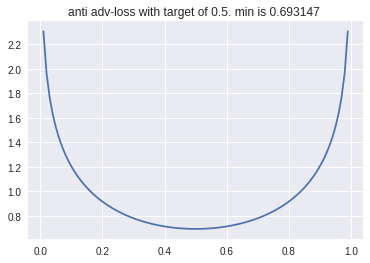

In [9]:



# semantic_encoder : take sentence return a vector with only semantics
# semantic similiary objective: given a pair of sentences with the same semantics,
#    expect their results to be close (MeanSquared)    

# see idea from https://github.com/edenton/drnet-py/blob/master/models/classifiers.py
# in her train method:
# FRAMES: VID A: FRAME 1 x_c1 , ?x_p2? (1/2 of times)
#                FRAME 2 x_c2 , x_p1
#         VID B: FRAME 1      , ?x_p2? (1/2 of times)
#  
# x_p1,x_p2 chosen randonly from same/not-same video
# x_c1,x_c2 are always same-video
# c1 and p1 are same content, different pose.

# train_scene_discriminator()
# h_p1,h_p2 = netEP applied to x[0],x[1]. assumption: SAME VIDEO
# important: detach both!
# override half of h_p2 by random-permutations of the batch. 
#   [1,2,3,4,5,6]
#   [2,3,1,4,5,6] after 1st half permute
#   [1,1,1,0,0,0] set unequal the labels (1=unequal, 0 equal. does it matter? should it be 0.9,0.1?)
# apply BCE on inpit: concat of [h_p1,h_p2] 
# run backward, and optimizer on the netC classifier ONLY! emphasize! not on the encoder


# train()
# h_c1,h_c2 = netEC(x_c1), netEC(x_c2)  where input is x[0],x[1] sim loss is MSE directly on the hidden content-semantics
# h_p1,h_p2 = netEP(x_p1),netEP(x_p2) where input is x[2],x[3]
# rec = netD([h_c1, h_p1]) h_c1 is DIFFERENT FRAME , but same content, than h_p1
# netC is the semantic-discriminator given h_p1,h_p2, target 0.5 (max-entropy). 
# emphasize! don't optimize netC is this stage


# ANTI-ADVERSERTIAL LOSS FUNCTION, target is 0.5, so min value is 0.6931471805599453
%matplotlib inline
import matplotlib.pyplot as plt
x = np.arange(1,100)/100.0
plt.title("anti adv-loss with target of 0.5. min is 0.693147 ")
plt.plot(x, -0.5*(np.log(x)+np.log(1-x)))

## PARAMS

In [10]:
import argparse
import sys
parser = argparse.ArgumentParser()

parser.add_argument('--epocs', type=int, default=2, help='number of epochs to train for')
parser.add_argument('--epoch_size', type=int, default=600, help='epoch size')
parser.add_argument('--batch_size', default=100, type=int, help='batch size')

parser.add_argument('--optimizer', default='adam', help='optimizer to train with. only Adam supported')
parser.add_argument('--lr', default=0.02, type=float, help='learning rate. source=0.002')
parser.add_argument('--adv_disc_lr', default=0.002, type=float, help='learning rate')

parser.add_argument('--beta1', default=0.5, type=float, help='momentum term for adam')

parser.add_argument('--semantics_dim', type=int, default=20, help='size of the semantics vector')
parser.add_argument('--style_dim', type=int, default=5, help='size of the style vector')
parser.add_argument('--sd_weight', type=float, default=0.001, help='weight on adversarial loss 0.0001 originally. reducing')

parser.add_argument('--max_sent_len', type=int, default=50, help='max size of sentence. sentences typically will be shorter')


'''
parser.add_argument('--max_step', type=int, default=20, help='maximum distance between frames')
parser.add_argument('--seed', default=1, type=int, help='manual seed')
parser.add_argument('--log_dir', default='logs', help='base directory to save logs')
parser.add_argument('--data_root', default='', help='root directory for data')

parser.add_argument('--dataset', default='moving_mnist', help='dataset to train with')

parser.add_argument('--sd_nf', type=int, default=100, help='number of layers')
parser.add_argument('--content_model', default='dcgan_unet', help='model type (dcgan | dcgan_unet | vgg_unet)')
parser.add_argument('--pose_model', default='dcgan', help='model type (dcgan | unet | resnet)')
parser.add_argument('--data_threads', type=int, default=5, help='number of parallel data loading threads')
parser.add_argument('--data_type', default='drnet', help='speed up data loading for drnet training')
'''
sys.argv=["nothing"]
opt = parser.parse_args()
print (opt.lr,opt.beta1)

0.02 0.5


# Define Encoder, Decoder

In [0]:
?EncoderRNN
#?DecoderRNN

#   decoders

In [153]:
#trn_dl = DataLoader(TimePairsDataset(1e5,1), batch_size=opt.batch_size,)
#x,y = next(iter(trn_dl)) 
#print ('input . x is vertically stacked sentences',x.shape,'y',y.shape)
#batch,pair,sentence_len=x.shape

from seq2seq.models import EncoderRNN
from torch import nn

class EncoderWrapper(nn.Module):
  """ wraps encoder, accpet in forward tuple of (data,len). return last hidden"""
  def __init__(self,encoder):
    super(EncoderWrapper,self).__init__()
    self.encoder = encoder
  
  def forward(self,inp):

      #in_data,in_len = in_tuple
      output,hidden = self.encoder(*inp)#in_data,in_len)
      # **output** (batch, seq_len, hidden_size): tensor containing the encoded features of the input sequence
      # **hidden** (num_layers * num_directions, batch, hidden_size): tensor containing the features in the hidden state `h`
      return hidden[0,:,:]

 
adv_disc = nn.Sequential(
  # input concat of two style
  nn.Linear(2*opt.style_dim,6),
  nn.ReLU(inplace=True),
  nn.Linear(6,1),
  nn.Sigmoid()  #Must be sigmoid, we apply later BCE
)


variable_lengths = False  # True means batch is ordered. this can't be done as sent0.len!=sent1.len
en_sem = EncoderWrapper(EncoderRNN(len(TEXT.vocab),opt.max_sent_len, opt.semantics_dim,variable_lengths =variable_lengths))
en_sty = EncoderWrapper(EncoderRNN(len(TEXT.vocab),opt.max_sent_len, opt.style_dim, variable_lengths = variable_lengths))
decoder = DecoderRNN(len(TEXT.vocab),opt.max_sent_len, opt.semantics_dim + opt.style_dim,sos_id=TEXT_TARGET.sos_id,eos_id=TEXT_TARGET.eos_id)
#adv_disc = Discriminator(EncoderRNN(len(TEXT.vocab),opt.max_sent_len, opt.style_dim, variable_lengths =variable_lengths),
#                         opt.style_dim)


sample = next(train_iter)
print (type(sample.sent_0))
in_var,in_len=sample.sent_0
#print (in_var[:2],in_len[:2])
sem_out = en_sem(sample.sent_0)
print ('result of en_sem',sem_out.shape)   #[1, 32, 20]
sty_out = en_sty(sample.sent_1)
print ('sty_out',sty_out.shape,
      'concat',torch.cat([sty_out, sty_out],dim=1).shape)
disc_out = adv_disc(torch.cat([sty_out, sty_out],dim=1))
print (disc_out.shape)

merged = torch.cat([sem_out,sty_out],dim=1)
merged.unsqueeze_(0)
print ('merged',merged.shape)
decoder_outputs, _,_ = decoder(inputs=None,  # pass not None for teacher focring  (batch, seq_len, input_size)
                          encoder_hidden=merged, #(num_layers * num_directions, batch_size, hidden_size)
                          encoder_outputs = None, # pass not None for attention
                          teacher_forcing_ratio=0 #range 0..1 , must pass inputs if >0
                         ) 
#**decoder_outputs** (seq_len, batch, vocab_size): list of tensors with size (batch_size, vocab_size) containing
#          the outputs of the decoding function.
print ('decoder_outputs',len(decoder_outputs),decoder_outputs[0].shape)




if opt.optimizer=='adam':
  optimizer = torch.optim.Adam

optimizer_en_sem = optimizer(en_sem.parameters(), lr=opt.lr) #(, betas=(opt.beta1, 0.999))
optimizer_en_sty = optimizer(en_sty.parameters(), lr=opt.lr) #), betas=(opt.beta1, 0.999))
optimizer_decoder = optimizer(decoder.parameters(), lr=0.1) #)opt.lr), betas=(opt.beta1, 0.999))
optimizer_adv_disc = optimizer(adv_disc.parameters(), lr=opt.adv_disc_lr) ##), betas=(opt.beta1, 0.999))
 

<class 'tuple'>
result of en_sem torch.Size([32, 20])
sty_out torch.Size([32, 5]) concat torch.Size([32, 10])
torch.Size([32, 1])
merged torch.Size([1, 32, 25])
decoder_outputs 50 torch.Size([32, 43])


In [0]:
import logging
import traceback
 
def handleError(self, record):
    traceback.print_stack()
logging.Handler.handleError = handleError

# Train loop

In [176]:


# --------- training funtions ------------------------------------
def train(b):

    en_sty.zero_grad() 
    en_sem.zero_grad()
    decoder.zero_grad()

    # x[0] semantic0   , style0
    # x[1] semantic0   , style1   
    # x[2] semantic0orX, style0 (1/2 the time 0 , half X)

    #sent0 = x[:,0]
    #sent1 = x[:,1]
    #sentX = x[:,2]

    sent0 = b.sent_0
    sent1 = b.sent_1
    sentX = b.sent_x
    recon_target = b.sent_0_target  #one-hot
    
    logger.debug('sent0',sent0[0].shape,sent0[1].shape)
    h_sem0 = en_sem(sent0) 
    h_sem1 = en_sem(sent1) 
    print('h_sem0 shape',h_sem0.shape)
    # if you want to use torch criterion, you need to copy the label and set it to not requreing gradiant
    # so below is different than nn.MSELoss()(h_sem0,h_sem1.detach()). I wonder if only one get grad updates!
    sim_loss = torch.mean(torch.pow(  h_sem0- h_sem1,2)) 
    #sim_loss = mse_criterion(h_c1[0] if opt.content_model[-4:] == 'unet' else h_c1, h_c2)
    
    
    h_sty0 = en_sty(sent0)
    merged= torch.cat([h_sem1,h_sty0],dim=1)
    merged.unsqueeze_(0) #32x25 -> 1x32x25 . 1 is for one hidden-layer (not-stacked)
    print('h_sem1.h_sty0',h_sem1.shape,h_sty0.shape,merged.shape)
    recon_sent0, _,_ = decoder(inputs=None,  # pass not None for teacher focring  (batch, seq_len, input_size)
                          encoder_hidden=merged, #(num_layers * num_directions, batch_size, hidden_size)
                          encoder_outputs = None, # pass not None for attention
                          teacher_forcing_ratio=0 #range 0..1 , must pass inputs if >0
                         ) 
    
    # calc loss.
    print('$'*10,'recon_sent0 length',len(recon_sent0),'each',recon_sent0[0].shape)
    #rec_loss = nn.MSELoss()(recon_sent0,sent0)
    # see impl https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/loss/loss.py
    acc_loss, norm_term=0,0
    print('recon_target',recon_target.shape,'while decoder outputs',len(decoder_outputs))
    #target shape [32, 26]  batch x words , actual len of 50
    for step, step_output in enumerate(decoder_outputs):
      batch_size = recon_target.size(0)
      #print('step_output at step ',step,step_output.shape,type(step_output))
      outputs = step_output.contiguous().view(batch_size, -1)
      # what to do if output is too-long? decision here is to match only relevant parts
      if step+1>=recon_target.size(1):  
        break
      gold = recon_target[:, step + 1] #tuple [0] is data. [1] is len
      #print('output at step ',step,outputs.shape,type(outputs),'gold',gold.shape,type(gold))
      
      acc_loss += nn.NLLLoss()(outputs, gold) #TODO: why MSE???
      norm_term += 1
    rec_loss = acc_loss/norm_term
    

    # TODO : willl it be better to use completely different sentences?
    h_styX = en_sty(sentX)
    adv_disc_p =  adv_disc(torch.cat([h_sty0,h_styX],dim=1))
    
    logger.debug (adv_disc_p[0:3].data.numpy().T)
    adv_target = torch.FloatTensor(np.full(shape =(sent0.shape[0],1),fill_value=0.5))
    # the loss below is a parabula with min at log(0.5)=0.693... see documentation above
    adv_disc_loss = nn.BCELoss()(adv_disc_p, adv_target) - np.log(0.5)
    #print (adv_disc_loss)
    
    # full loss
    loss = rec_loss #+ sim_loss + opt.sd_weight*adv_disc_loss
    loss.backward()

    optimizer_en_sem.step()
    optimizer_en_sty.step()
    optimizer_decoder.step()

    return sim_loss.data.cpu().numpy(),rec_loss.data.cpu().numpy(),adv_disc_loss.data.cpu().numpy()*opt.sd_weight

def train_scene_discriminator(b):
    #print ('train_scene_discriminator',x.shape,y.shape)
    
    #sent0 = x[:,0]
    #sentX = x[:,2]
    sent0 = b.sent_0
    sentX = b.sent_x
    y = b.is_x_0
    #logger.debug('y',y.shape,y.type())
    
    adv_disc.zero_grad()

    h_sty0    = en_sty(sent0) #detach?
    h_sty0or2 = en_sty(sentX)
    
  
    out = adv_disc(torch.cat([h_sty0, h_sty0or2],dim=1))
    logger.debug('adv_disc out',out.shape,'is_x_0',y.shape)
    #TODO: #Note BCELossWithLogits is faster and moer stable, to use it remove sigmoid from network end
    bce = nn.BCELoss()(out.flatten(), y) #should wrapp in varaible? 

    bce.backward()
    optimizer_adv_disc.step()
    #print (out.shape) #torch.Size([16, 1])
    acc =  np.round(out.detach().numpy())==y  #CHECK THIS DIMENSTIONS!!! 
    #print (acc.shape) #1,16
    acc = acc.reshape(-1).float()
    acc= acc.sum()/len(acc)
    return bce.data.cpu().numpy(), acc.numpy()

# --------- training loop ------------------------------------
#train_ds = TimeStyleDataset(1e9,1)
#eval_ds  = TimeStyleDataset(1e9,2)
#training_batch_generator = iter(DataLoader(train_ds,batch_size=opt.batch_size))
#eval_batch_generator = iter(DataLoader(eval_ds,batch_size=opt.batch_size))
training_batch_generator = train_iter  #defined in the notebook start
eval_batch_generator = eval_iter 
b = next(training_batch_generator)

  
opt.epocs=20 
opt.epoch_size=30
opt.batch_size= 32 #anti-adv-loss will be noiser

logger.setLevel(logging.DEBUG)  
for epoch in range(opt.epocs):
    #print ('new epoch')
    en_sty.train()  # and not eval() mode
    en_sem.train()
    decoder.train()
    adv_disc.train()
    epoch_sim_loss, epoch_rec_loss, epoch_anti_disc_loss, epoch_sd_loss, epoch_sd_acc = 0, 0, 0, 0, 0

    for i in range(opt.epoch_size):
        #if i % 100==0 : print ('batch',i,'of',opt.epoch_size)
        b = next(training_batch_generator)

        # train scene discriminator
        logger.debug ('b_sent_0',b.sent_0[0].shape,b.sent_0[1].shape)#TEXT.reverse(b.sent_0))

        sd_loss, sd_acc = train_scene_discriminator(b)
        epoch_sd_loss += sd_loss
        epoch_sd_acc += sd_acc

        # train main model
        sim_loss, rec_loss, anti_disc_loss = train(b)
        epoch_sim_loss += sim_loss
        epoch_rec_loss += rec_loss
        epoch_anti_disc_loss += anti_disc_loss
    #print (epoch, epoch_rec_loss/opt.epoch_size, epoch_sim_loss/opt.epoch_size)
    #print (epoch_sd_acc/opt.epoch_size)
    #print (epoch*opt.epoch_size*opt.batch_size)
    print('[%02d] rec loss: %.4f | sim loss: %.4f | anti_disc_loss: %.4f || scene disc %.4f %.3f%% ' % (epoch, epoch_rec_loss/opt.epoch_size, 
                epoch_sim_loss/opt.epoch_size, epoch_anti_disc_loss/opt.epoch_size,
                epoch_sd_loss/opt.epoch_size, 100*epoch_sd_acc/opt.epoch_size))
    logger.setLevel(logging.INFO)

# back to eval mode
en_sty.eval()  # and not eval() mode
en_sem.eval()
decoder.eval()
adv_disc.eval()
print ('training loop done')
# TODO: save the model





  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/z

h_sem0 shape torch.Size([32, 20])
h_sem1.h_sty0 torch.Size([32, 20]) torch.Size([32, 5]) torch.Size([1, 32, 25])
$$$$$$$$$$ recon_sent0 length 50 each torch.Size([32, 43])
recon_target torch.Size([32, 25]) while decoder outputs 50


AttributeError: ignored

In [17]:
''' BCE dynamics
bce=lambda a,p: nn.BCELoss()(torch.tensor(a),torch.tensor(p)).numpy()
#p= np.array([[0.5001803,  0.50018024, 0.5001803 ]])
p = np.array([[1.0,1.0,1.0]]); a = np.array([[0.0,0.0,0.0]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[1.0,1.0,1.0]]); a = np.array([[1.0,0.0,0.0]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[1.0,1.0,0.0]]); a = np.array([[0.5,0.5,0.5]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[0.5,0.5,0.5]]); a = np.array([[0.5,0.5,0.5]]); loss = bce(p,a) ; print (a,p,loss)
p = np.array([[0.6,0.4,0.5]]); a = np.array([[0.5,0.5,0.5]]); loss = bce(p,a) ; print (a,p,loss)

#       -1*( y* log(p) + (1-y) log(1-p) )
#p=0.5  -1   y* 0.693  + (1-y)* 0.693  == -0.693 (y+1-y) = -0.693

#a=0.5  -1* (0.5*log(p)+ 0.5*log(1-p)) = -0.5(log(p)+log(1-p))
'''
1

1

In [0]:
??DecoderRNN

# EVAL

In [32]:
eval_ds=  TimePairsDataset(1e7,2)
eval_batch_generator=iter(DataLoader(eval_ds,batch_size=3))
x,y = next(eval_batch_generator)
print (x.shape,y.shape)

sent0 = None    # x[0] semantic0   , style0
sent1 = x[:,1]  # x[1] semantic0   , style1 
sent2 = x[:,2]  # x[2] semantic0orX, style0 (1/2 the time 0 , half X)

h_sem = en_sem(sent1)
h_sty = en_sty(sent2)
p = decoder(torch.cat([h_sem,h_sty],dim=1))
  
for i in range(len(x)) :
  print ('source sent. take semantics: ',eval_ds.untokenize_tokens(sent1[i]))
  print ('target sent. take style    : ',eval_ds.untokenize_tokens(sent2[i]))
  print ('target sent                : ',eval_ds.untokenize_tokens(p[i]))
  print ('\n')
  
  
  
  

torch.Size([3, 3, 20]) torch.Size([3, 1])
source sent. take semantics:  Jan 01 1970 00:00:02
target sent. take style    :  04/Apr/1970 22:51:53
target sent                :  ;MS3EJ&1970 06:00:35


source sent. take semantics:  Jan 01 1970 00:00:02
target sent. take style    :  01/Jan/1970 00:00:02
target sent                :  ;MS3EJ&1970 06:00:35


source sent. take semantics:  Jan 01 1970 00:00:02
target sent. take style    :  02/Feb/1970 11:32:26
target sent                :  ;MS3EJ&1970 06:00:35




In [0]:
#from here: http://anie.me/On-Torchtext/
from torchtext.data import Field
import torch
import torch.nn

class SplitReversibleField(Field):

    def __init__(self, untokenize_char='', **kwargs):
        super(SplitReversibleField, self).__init__(**kwargs)
        self.untokenize_char = untokenize_char
        

    def reverse(self, batch):

        if not self.batch_first:
            batch = batch.t()
        with torch.cuda.device_of(batch):
            batch = batch.tolist()
        batch = [[self.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

        def trim(s, t):
            sentence = []
            for w in s:
                if w == t:
                    break
                sentence.append(w)
            return sentence

        batch = [trim(ex, self.eos_token) for ex in batch]  # trim past frst eos

        def filter_special(tok):
            return tok not in (self.init_token, self.pad_token)

        batch = [filter(filter_special, ex) for ex in batch]
        return [self.untokenize_char.join(ex) for ex in batch]

# MY EncoderRNN self made buggy start of result

In [0]:
import torch
import torch.nn as nn
%matplotlib inline

sample = next(train_iter)
device='cpu'
'''
class MyEncoderRNN(nn.Module):  #see https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def __init__(self, vocab_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """ input:  1xbs :  example: 1   x 32
            hidden: hxbs :  example: 100 x 32
        """
        print ('EncoderRNN input',input.shape, 'hidden',hidden.shape)
        assert input.shape[1]==hidden.shape[1] # batch
        assert input.shape[0]==1
        assert hidden.shape[0]==self.hidden_size
        
        
        embedded = self.embedding(input).view(1, input.shape[1], -1)
        print (embedded.shape)
        output, hidden = self.gru(embedded, hidden) #input must be 3 dimension
        return output, hidden

    def init_hidden(self,batch_size):
        return torch.zeros( 1, self.hidden_size,batch_size, device=device)  

class Encoder(nn.Module):
    def __init__(self, encoder_rnn):
        """ wrapper around EncoderRNN running on a full sequence in one fwd pass """
        super(Encoder, self).__init__()
        self.encoder_rnn = encoder_rnn
    
    def forward(self, input):
        print (input.shape)
        sen_len, batch_size = input.shape
        h= self.encoder_rnn.init_hidden(batch_size)
        for i in range(sen_len):
          o,h = self.encoder_rnn(input[i:i+1], h)
        return h


class MyDecoderRNN(nn.Module):
    def __init__(self, input_hidden_size, output_vocab_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
      
      
#decoder= MyDecoderRNN(opt.semantics_dim+opt.style_dim)   


en_sem = Encoder(EncoderRNN(len(TEXT.vocab), opt.semantics_dim))
en_sty = Encoder(EncoderRNN(len(TEXT.vocab), opt.style_dim))

en_sem(sample.sent_0)
'''
1

1

# where this code came from?

In [0]:

'''
      
en_sem = nn.Sequential(
  # expect sentence_len,so from outside, cut a pair into x[0],x[1] and pass seperatly each
  nn.Linear(sentence_len,19),
  nn.ReLU(inplace=True), 
  nn.Linear(19,opt.semantics_dim),
  #nn.Tanh()
)

en_sty= nn.Sequential(
  nn.Linear(sentence_len,19),
  nn.ReLU(inplace=True),
  nn.Linear(19,opt.style_dim),
  #nn.Tanh()
)
decoder = nn.Sequential(
  # input concat of semantic and style
  # output sentence_len , each word/char has currently value in range 0..1
  nn.Linear(opt.semantics_dim+opt.style_dim,19),
  nn.ReLU(inplace=True),
  nn.Linear(19,60),
  nn.ReLU(inplace=True),
  nn.Linear(60,sentence_len),
  # we apply MSE on this
)
adv_disc = nn.Sequential(
  # input concat of two style
  nn.Linear(2*opt.style_dim,6),
  nn.ReLU(inplace=True),
  nn.Linear(6,1),
  nn.Sigmoid()  #Must be sigmoid, we apply later BCE
)
'''

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
'''from torch.utils.data import Dataset#, DataLoader
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline

class TimePairsDataset(Dataset):
  
  def __init__(self,length,time_mod_3_result): #1e9 means 1970-2001
    """
    time_mod_3_result - to make sure time is train/test/valid is different, pass
    a different result here.
    """
    #super().__init__()
    self.length = length
    self.formats = ["%b %d %Y %H:%M:%S", "%m/%b/%Y %H:%M:%S"] # STAY WITH 2 STYLES, DISCRIMINATOR SIMPLER #"%d %b %Y %H:%M:%S",
    self.time_mod_3_result=time_mod_3_result
  
  
  def __len__(self):
    return int(self.length)
  
  def _choose(self,idx,style):
    st = time.strftime(self.formats[style],time.gmtime(idx))
    return np.array([ord(c) for c in list(st)][:24],np.float32)/120 #chars are up to that
  
  def untokenize_sample(self,sample):
    """ sample x and y, x contains multiple sentences"""
    x,y = sample
    out=[] 
    for tokens in x:    
      out.append(self.untokenize_tokens(tokens) )
    return out,y

  def untokenize_tokens(self,tokens):
    """ one sentence"""
    if type(tokens)==torch.Tensor:
      tokens = tokens.detach().numpy()
    return ''.join([chr(int(round(token*120))) for token in tokens])
  
  
  def _tvt(self,idx):
    # for 10, if train, return 9, valid 10, test 11
    return (idx//3) * 3 + self.time_mod_3_result #10//3 * 3 + x = 9+x
  
  def __getitem__(self,idx):
    """ x -  x[0] semantic0   , style0
             x[1] semantic0   , style1   
             x[2] semantic0orX, style0 (1/2 the time 0 , half X)
    """
    
    #other_idx is 50% same, 50% other
    other_idx = (idx + np.random.randint(0,2)*(np.random.randint(10,self.length))) %self.length
    #print (idx,other_idx)
    idx = self._tvt(idx)
    other_idx = self._tvt(other_idx)
    #print (idx,other_idx)
    
    # two random formats
    random_fs= np.random.choice(len(self.formats),size=2,replace=False)
    #print (random_fs)
    x_list = []
    x_list.append(self._choose(idx,random_fs[0]))
    x_list.append(self._choose(idx,random_fs[1]))
    x_list.append(self._choose(other_idx,random_fs[0]))
    
    y = np.array([idx==other_idx],np.float32)
    
   
    return  (np.vstack(x_list), y)

def test():
  dataset = TimePairsDataset(1e9,1)
  sample = dataset[9] ;#print (sample)
  print (dataset.untokenize_sample(sample))
  print ('shapes x,y',sample[0].shape,sample[1].shape)
  
test()
'''